# Cluster 14 vs Cluster 15 – Intake Comparison (Public CAISO Data)

This notebook extends the repo beyond Cluster 15 by introducing a historical intake snapshot for **Cluster 14**.

**What this notebook is (and isn’t):**
- Compares **what entered the queue** (intake characteristics) across cohorts.
- Produces distributional insights (MW + technology mix; Cluster 14-only grid context fields).
- Does **not** claim project-level outcomes for Cluster 14 (public data does not provide joinable longitudinal IDs).

**Inputs:**
- `data/raw/PreliminaryCluster14ProjectListasofMay20-2021.xlsx`
- `data/processed/cluster15_clean.csv` (from Notebook 03)

**Outputs:**
- Cleaned Cluster 14 intake table saved to `data/processed/cluster14_intake_clean.csv`
- Figures saved to `outputs/figures/`
- Tables saved to `outputs/tables/`


## 1) Imports

In [18]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print('Python:', sys.version)
print('Executable:', sys.executable)


Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Executable: C:\Users\danci\Interconnection-Queue-Intelligence\.venv\Scripts\python.exe


## 2) Paths + outputs folders

This repo supports running notebooks either from the repo root or from `notebooks/`.

In [19]:
ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

RAW = ROOT / "data" / "raw"
PROCESSED = ROOT / "data" / "processed"

OUTPUTS = ROOT / "outputs"
FIGURES = OUTPUTS / "figures"
TABLES = OUTPUTS / "tables"

PROCESSED.mkdir(parents=True, exist_ok=True)
FIGURES.mkdir(parents=True, exist_ok=True)
TABLES.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("RAW exists:", RAW.exists(), RAW)
print("PROCESSED exists:", PROCESSED.exists(), PROCESSED)


ROOT: C:\Users\danci\Interconnection-Queue-Intelligence
RAW exists: True C:\Users\danci\Interconnection-Queue-Intelligence\data\raw
PROCESSED exists: True C:\Users\danci\Interconnection-Queue-Intelligence\data\processed


## 3) Load Cluster 14 intake snapshot (raw)

This file is a *preliminary* Cluster 14 project list captured at a point in time (May 2021).
It is an **intake snapshot**, not an outcome dataset.

In [20]:
C14_PATH = RAW / "PreliminaryCluster14ProjectListasofMay20-2021.xlsx"

xl = pd.ExcelFile(C14_PATH)
print("Sheets:", xl.sheet_names)

c14_raw = pd.read_excel(C14_PATH, sheet_name="C14 Prelim Cluster Overview")
c14_raw.shape


Sheets: ['Notes', 'C14 Prelim Cluster Overview']


(363, 12)

### Peek at Cluster 14 columns

In [21]:
list(c14_raw.columns)

['PTO',
 'Affected PTO',
 'Area',
 'Total MW @ POI',
 'Technology\n#1',
 'MW-T1',
 'Technology\n#2',
 'MW-T2',
 'Technology\n#3',
 'MW-T3',
 'POI',
 'Voltage\n(kV)']

## 4) Clean and standardize Cluster 14 intake table

We normalize headers and create a simplified technology label compatible with the Cluster 15 analysis.

Notes:
- Cluster 14 includes grid context fields (PTO, POI, Voltage) that are not present in the current Cluster 15 public export used in this repo.
- We keep these fields for Cluster 14-only exploration and mapping later.

In [22]:
# Standardize column names (trim whitespace, keep as-is otherwise)
c14 = c14_raw.copy()
c14.columns = [str(c).strip() for c in c14.columns]

RENAME = {
    "PTO": "pto",
    "Affected PTO": "affected_pto",
    "Area": "area",
    "Total MW @ POI": "total_mw_at_poi",
    "Technology\n#1": "tech_1",
    "MW-T1": "mw_t1",
    "Technology\n#2": "tech_2",
    "MW-T2": "mw_t2",
    "Technology\n#3": "tech_3",
    "MW-T3": "mw_t3",
    "POI": "poi",
    "Voltage\n(kV)": "voltage_kv",
}

missing = [k for k in RENAME.keys() if k not in c14.columns]
if missing:
    raise KeyError(f"Unexpected Cluster 14 schema; missing columns: {missing}")

c14 = c14.rename(columns=RENAME)

# Coerce numerics
for col in ["total_mw_at_poi", "mw_t1", "mw_t2", "mw_t3", "voltage_kv"]:
    c14[col] = pd.to_numeric(c14[col], errors="coerce")

# Clean text fields
for col in ["pto", "affected_pto", "area", "tech_1", "tech_2", "tech_3", "poi"]:
    c14[col] = c14[col].astype(str).str.strip().replace({"nan": np.nan, "None": np.nan})

c14.shape


(363, 12)

### Create a simplified technology category

We map CAISO technology text into a small set of analysis categories.
If a project has both Solar and Battery, we label it `Hybrid (Solar+Storage)`.

In [23]:
def norm_tech(x: str) -> str:
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if "battery" in s or "storage" in s:
        return "Battery"
    if "solar" in s or "pv" in s:
        return "Solar"
    if "wind" in s:
        return "Wind"
    if "geothermal" in s:
        return "Geothermal"
    if "hydro" in s:
        return "Hydro"
    if "gas" in s or "natural" in s:
        return "Gas"
    if "biomass" in s:
        return "Biomass"
    return "Other"

c14["tech_1_norm"] = c14["tech_1"].apply(norm_tech)
c14["tech_2_norm"] = c14["tech_2"].apply(norm_tech)
c14["tech_3_norm"] = c14["tech_3"].apply(norm_tech)

def classify_row(row):
    techs = {row.get("tech_1_norm"), row.get("tech_2_norm"), row.get("tech_3_norm")}
    techs.discard(np.nan)
    techs.discard(None)
    techs.discard("nan")
    techs = {t for t in techs if pd.notna(t)}
    if "Solar" in techs and "Battery" in techs:
        return "Hybrid (Solar+Storage)"
    # if only one dominant
    if len(techs) == 1:
        return list(techs)[0]
    if len(techs) == 0:
        return np.nan
    # multiple but not solar+storage
    return "Hybrid (Other)"

c14["technology"] = c14.apply(classify_row, axis=1)

# A "net_mw" field comparable to Cluster 15:
# We use the provided total MW at POI.
c14["net_mw"] = c14["total_mw_at_poi"]

c14[["technology", "net_mw"]].head()


,technology,net_mw
0,Hybrid (Solar+Storage),500.0
1,Hybrid (Solar+Storage),350.0
2,Battery,2000.0
3,Solar,350.0
4,Hybrid (Solar+Storage),700.0


### Save cleaned Cluster 14 intake table

In [24]:
C14_OUT = PROCESSED / "cluster14_intake_clean.csv"
c14.to_csv(C14_OUT, index=False)
print("Saved:", C14_OUT)
print("Rows:", len(c14))


Saved: C:\Users\danci\Interconnection-Queue-Intelligence\data\processed\cluster14_intake_clean.csv
Rows: 363


## 5) Load Cluster 15 cleaned table

Cluster 15 in this repo includes an observed status (active/withdrawn) and timing deltas.
For intake comparison, we focus on `technology` and `net_mw`.

In [25]:
c15 = pd.read_csv(PROCESSED / "cluster15_clean.csv")
c15.shape, c15.columns.tolist()[:12]

((170, 27),
 ['queue_number',
  'project_number',
  'project_name',
  'fuel_1',
  'fuel_2',
  'fuel_3',
  'mw_1',
  'mw_2',
  'mw_3',
  'net_mw',
  'county',
  'state'])

## 6) Intake comparison: MW distributions

We compare the distributions of proposed project MW at intake for Cluster 14 vs Cluster 15.
This is not a survival outcome comparison for Cluster 14—only intake composition.

In [26]:
# Basic summary stats
mw_summary = pd.DataFrame({
    "cluster14_net_mw": c14["net_mw"].describe(),
    "cluster15_net_mw": c15["net_mw"].describe(),
})
mw_summary

,cluster14_net_mw,cluster15_net_mw
count,363.000000,170.000000
mean,291.998033,495.695573
std,263.516511,464.711599
min,0.000000,10.072000
25%,125.000000,204.907500
50%,210.000000,365.542000
75%,400.000000,558.482333
max,2000.000000,2346.960000


### Save: MW summary table

In [27]:
mw_summary.to_csv(TABLES / "intake_mw_summary_c14_vs_c15.csv")
print("Saved:", TABLES / "intake_mw_summary_c14_vs_c15.csv")

Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\tables\intake_mw_summary_c14_vs_c15.csv


### Figure: MW histogram (log x)

Interconnection MW is typically heavy-tailed, so we use a log-scale x-axis.

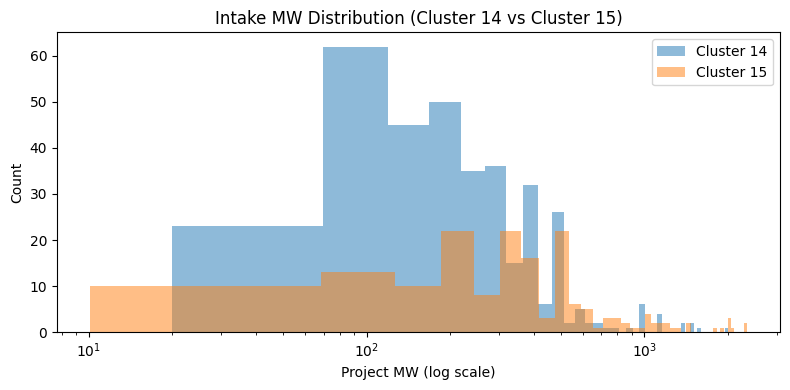

Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\figures\intake_mw_hist_c14_vs_c15.png


In [28]:
# Filter to positive MW
c14_mw = c14["net_mw"].dropna()
c14_mw = c14_mw[c14_mw > 0]

c15_mw = c15["net_mw"].dropna()
c15_mw = c15_mw[c15_mw > 0]

plt.figure(figsize=(8,4))
plt.hist(c14_mw, bins=40, alpha=0.5, label="Cluster 14")
plt.hist(c15_mw, bins=40, alpha=0.5, label="Cluster 15")
plt.xscale("log")
plt.title("Intake MW Distribution (Cluster 14 vs Cluster 15)")
plt.xlabel("Project MW (log scale)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES / "intake_mw_hist_c14_vs_c15.png", dpi=200)
plt.show()

print("Saved:", FIGURES / "intake_mw_hist_c14_vs_c15.png")


## 7) Intake comparison: technology mix

We compare technology shares at intake for Cluster 14 vs Cluster 15.
Cluster 15 technology categories come from your cleaning logic in Notebook 03.

In [29]:
c14_tech = c14["technology"].value_counts(dropna=False)
c15_tech = c15["technology"].value_counts(dropna=False)

tech_compare = pd.DataFrame({
    "c14_count": c14_tech,
    "c15_count": c15_tech,
}).fillna(0).astype(int)

tech_compare["c14_share"] = tech_compare["c14_count"] / tech_compare["c14_count"].sum()
tech_compare["c15_share"] = tech_compare["c15_count"] / tech_compare["c15_count"].sum()

tech_compare.sort_values("c15_count", ascending=False)


,c14_count,c15_count,c14_share,c15_share
technology,,,,
other,0,170,0.000000,1.0
Battery,216,0,0.595041,0.0
Hybrid (Other),6,0,0.016529,0.0
Geothermal,1,0,0.002755,0.0
Hybrid (Solar+Storage),115,0,0.316804,0.0
Other,2,0,0.005510,0.0
Solar,14,0,0.038567,0.0
Wind,9,0,0.024793,0.0


### Save: technology mix table

In [30]:
tech_compare.to_csv(TABLES / "intake_technology_mix_c14_vs_c15.csv")
print("Saved:", TABLES / "intake_technology_mix_c14_vs_c15.csv")

Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\tables\intake_technology_mix_c14_vs_c15.csv


### Figure: technology share comparison

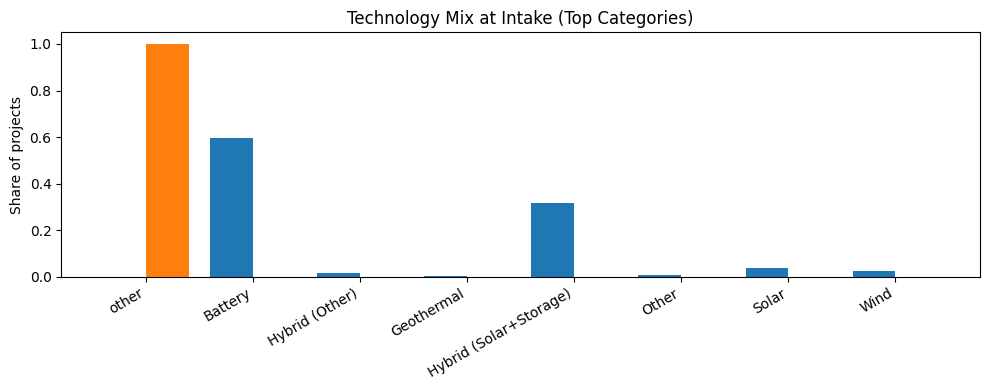

Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\figures\intake_tech_share_c14_vs_c15.png


In [31]:
# Plot only the top categories to keep it readable
plot_df = tech_compare.sort_values("c15_share", ascending=False).head(10)

x = np.arange(len(plot_df.index))
width = 0.4

plt.figure(figsize=(10,4))
plt.bar(x - width/2, plot_df["c14_share"], width, label="Cluster 14")
plt.bar(x + width/2, plot_df["c15_share"], width, label="Cluster 15")
plt.xticks(x, plot_df.index, rotation=30, ha="right")
plt.title("Technology Mix at Intake (Top Categories)")
plt.ylabel("Share of projects")
plt.tight_layout()
plt.savefig(FIGURES / "intake_tech_share_c14_vs_c15.png", dpi=200)
plt.show()

print("Saved:", FIGURES / "intake_tech_share_c14_vs_c15.png")


## 8) Cluster 14-only: POI concentration and grid context

Cluster 14 includes POI and voltage. We summarize the most common POIs and PTOs.
This can later support mapping and POI-level risk heuristics.

In [ ]:
top_poi = c14["poi"].value_counts().head(20).rename("project_count").to_frame()
top_pto = c14["pto"].value_counts().head(20).rename("project_count").to_frame()
voltage_dist = c14["voltage_kv"].value_counts().sort_index().rename("project_count").to_frame()

top_poi.head(), top_pto.head(), voltage_dist.head()

### Save: Cluster 14 POI / PTO / voltage tables

In [ ]:
top_poi.to_csv(TABLES / "cluster14_top_pois.csv")
top_pto.to_csv(TABLES / "cluster14_top_ptos.csv")
voltage_dist.to_csv(TABLES / "cluster14_voltage_distribution.csv")

print("Saved:", TABLES / "cluster14_top_pois.csv")
print("Saved:", TABLES / "cluster14_top_ptos.csv")
print("Saved:", TABLES / "cluster14_voltage_distribution.csv")


### Figure: Cluster 14 voltage distribution

In [ ]:
plt.figure(figsize=(8,4))
voltage_dist["project_count"].plot(kind="bar")
plt.title("Cluster 14 – Voltage at POI (kV)")
plt.xlabel("Voltage (kV)")
plt.ylabel("Project count")
plt.tight_layout()
plt.savefig(FIGURES / "cluster14_voltage_distribution.png", dpi=200)
plt.show()

print("Saved:", FIGURES / "cluster14_voltage_distribution.png")


## Key takeaways

- Cluster 14 spreadsheet provides **project-level intake** fields (PTO, POI, Voltage) that are not present in the Cluster 15 export used in this repo.
- Because public CAISO data does not provide stable join keys over time, this notebook focuses on **distributional comparisons** (MW + tech mix) rather than project-level survival for Cluster 14.
- These intake comparisons are useful context for interpreting Cluster 15 survivability patterns and for building a canonical multi-cluster dataset over time.
